<a href="https://colab.research.google.com/github/eduardoplima/data-science-notebooks/blob/main/clustering-credit-data-pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de clusters em dados de cartão de crédito

Este notebook tem como objetivo explorar técnicas de análise de agrupamento (clustering) aplicadas a dados financeiros, utilizando o Credit Card Dataset for Clustering, disponível publicamente no Kaggle. Este conjunto de dados resume o comportamento de uso de aproximadamente 9.000 titulares ativos de cartões de crédito durante os últimos 6 meses, incluindo informações como saldo, frequência de compras, limite de crédito e pagamentos mínimos. A tabela a seguir descreve os campos disponíveis no dataset:

| Campo                             | Descrição                                                                                  |
|-----------------------------------|--------------------------------------------------------------------------------------------|
| `CUST_ID`                         | Identificação do titular do cartão de crédito (Categórico)                                 |
| `BALANCE`                         | Valor do saldo disponível na conta para realizar compras                                   |
| `BALANCE_FREQUENCY`              | Frequência com que o saldo é atualizado (0 = nunca, 1 = sempre)                            |
| `PURCHASES`                       | Valor total das compras realizadas                                                         |
| `ONEOFF_PURCHASES`               | Maior valor de compra feito em uma única transação                                         |
| `INSTALLMENTS_PURCHASES`         | Valor total de compras realizadas parceladamente                                           |
| `CASH_ADVANCE`                   | Valor de adiantamentos em dinheiro solicitados pelo usuário                               |
| `PURCHASES_FREQUENCY`           | Frequência das compras (0 = nunca, 1 = com frequência)                                     |
| `ONEOFFPURCHASESFREQUENCY`      | Frequência de compras em uma única transação (0 = nunca, 1 = com frequência)               |
| `PURCHASESINSTALLMENTSFREQUENCY`| Frequência de compras parceladas (0 = nunca, 1 = com frequência)                           |
| `CASHADVANCEFREQUENCY`          | Frequência de adiantamentos em dinheiro (0 = nunca, 1 = com frequência)                    |
| `CASHADVANCETRX`                | Número de transações de adiantamento em dinheiro                                           |
| `PURCHASES_TRX`                 | Número total de transações de compra                                                       |
| `CREDIT_LIMIT`                  | Limite de crédito do cartão                                                                |
| `PAYMENTS`                      | Valor total de pagamentos realizados                                                       |
| `MINIMUM_PAYMENTS`             | Valor mínimo dos pagamentos realizados                                                     |
| `PRCFULLPAYMENT`               | Percentual do valor total da fatura pago integralmente pelo usuário                        |
| `TENURE`                        | Tempo de relacionamento (em meses) com o serviço de cartão de crédito                      |


A análise de clustering permite identificar padrões de comportamento entre os clientes, agrupando-os com base em características semelhantes. Isso é especialmente útil para instituições financeiras que buscam segmentar sua base de clientes para estratégias de marketing direcionadas, avaliação de risco de crédito e desenvolvimento de produtos personalizados.
Pinterest

Neste estudo, aplicaremos diferentes técnicas de pré-processamento, como normalização, e utilizaremos o algoritmo de clustering K-Means. Avaliaremos a qualidade dos agrupamentos gerados por meio dos seguintes índices de validação:

* Inércia: a inércia mede o quão próximos os pontos estão do centro do seu cluster. É a soma das distâncias quadradas entre cada ponto e seu centroide. Valores menores indicam clusters mais compactos. No entanto, a inércia sempre diminui com o aumento de k, por isso deve ser usada com cautela — preferencialmente com o método do cotovelo..

* Índice de Davies-Bouldin: esse índice avalia a relação entre a dispersão dentro dos clusters e a separação entre eles. Valores menores indicam agrupamentos mais bem definidos e separados. Um DB próximo de 0 é ideal. Valores acima de 1,5 geralmente indicam sobreposição ou má separação entre os grupos.

* Silhueta: o índice de silhueta (ou silhouette) mede o quão bem cada ponto está agrupado em relação ao seu próprio cluster e aos clusters vizinhos. Varia de -1 a 1. Quanto mais próximo de 1, melhor a separação. Valores abaixo de 0 indicam que os pontos podem estar mal classificados.

Por fim, discutiremos os insights obtidos a partir dos resultados. Exploraremos formas de exibir os registros do dataset por meio dos algoritmos t-SNE e UMAP e veremos graficamente a divisão dos atributos entre os agrupamentos definidos.

# Configuração

In [ ]:
import kagglehub
import os
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")
filename = pathlib.Path(path).parent / os.listdir(path)[0]

In [ ]:
path = pathlib.Path(path)
csv_files = list(path.glob("*.csv"))

if csv_files:
    df = pd.read_csv(csv_files[0])
    print(f"Dataset carregado com sucesso: {csv_files[0].name}")
else:
    raise FileNotFoundError("Nenhum arquivo CSV encontrado no diretório baixado.")

Dataset carregado com sucesso: CC GENERAL.csv


In [ ]:
print(f'O dataset tem {len(df)} linhas.')

O dataset tem 8950 linhas.


In [ ]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
def generate_graph(df:pd.DataFrame, max_clusters:int, analysis_type:str):
  davies_bouldin_scores = []
  silhouette_scores = []
  inertias = []

  for k in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=43, n_init=10)
    kmeans.fit(df)
    clusters = kmeans.predict(df)

    db_score = davies_bouldin_score(df, clusters)
    davies_bouldin_scores.append(db_score)

    sil_score = silhouette_score(df, clusters)
    silhouette_scores.append(sil_score)

    inertias.append(kmeans.inertia_)

  #for k, db, sil in zip(range(2, max_clusters+1), davies_bouldin_scores, silhouette_scores):
  #  print(f"k = {k}: Davies-Bouldin Score = {db:.4f}, Silhouette Score = {sil:.4f}")

  plt.figure(figsize=(10, 6))
  plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
  plt.title(f'Score Silhueta vs. Número de agrupamentos (k) {analysis_type}')
  plt.xlabel('Número de agrupamentos (k)')
  plt.ylabel('Score Silhueta')
  plt.xticks(range(2, max_clusters+1))
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(10, 6))
  plt.plot(range(2, max_clusters+1), davies_bouldin_scores, marker='o')
  plt.title(f'Score Davies-Bouldin vs. Número de agrupamentos (k) {analysis_type}')
  plt.xlabel('Número de agrupamentos (k)')
  plt.ylabel('Score Davies-Bouldin')
  plt.xticks(range(2, max_clusters+1))
  plt.grid(True)
  plt.show()

  # Plotting the Elbow method (Inertia):
  plt.figure(figsize=(10, 6))
  plt.plot(range(2, max_clusters+1), inertias, marker='o')
  plt.title(f'Método Elbow (Inércia) vs. Número de agrupamentos (k) {analysis_type}')
  plt.xlabel('Método Elbow')
  plt.ylabel('Inércia')
  plt.xticks(range(2, max_clusters+1))
  plt.grid(True)
  plt.show()

  return davies_bouldin_scores, silhouette_scores, inertias


def remove_outliers_iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
  return df_filtered


# 🧹 Pré-processamento

Nesta etapa, realizamos o preparo inicial dos dados para aplicação dos algoritmos de agrupamento. Primeiramente, utilizamos o método `describe()` para obter uma visão estatística geral do conjunto de dados. Em seguida, removemos a coluna `CUST_ID`, que representa apenas a identificação do cliente e não contribui para a análise de clusters. Identificamos valores ausentes (`NaN`) nas colunas `CREDIT_LIMIT` e `MINIMUM_PAYMENTS`, que indicam, respectivamente, o limite de crédito disponível e o pagamento mínimo efetuado pelo cliente. Para tratar esses valores nulos, optamos por substituí-los pela média de cada coluna, garantindo a consistência dos dados sem introduzir distorções relevantes.




In [ ]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Identificando valores nulos

In [ ]:
df.drop('CUST_ID', axis=1, inplace=True)

In [ ]:
columns_with_nan = df.columns[df.isnull().any()].tolist()
print("Colunas com valores NaN:", columns_with_nan)

Colunas com valores NaN: ['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']


In [ ]:
nan_count_credit_limit = df['CREDIT_LIMIT'].isnull().sum()
nan_count_minimum_payments = df['MINIMUM_PAYMENTS'].isnull().sum()

print(f"Número de valores NaN em CREDIT_LIMIT: {nan_count_credit_limit}")
print(f"Número de valores NaN em MINIMUM_PAYMENTS: {nan_count_minimum_payments}")


Número de valores NaN em CREDIT_LIMIT: 1
Número de valores NaN em MINIMUM_PAYMENTS: 313


In [ ]:
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean(), inplace=True)

<ipython-input-11-0557c5a93da6>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
<ipython-input-11-0557c5a93da6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

# Análise dos dados

Nosso objetivo nesse notebook é examinar o comportamento de algoritmos de **clustering** aplicados a dados de uso de cartão de crédito. Utilizaremos diferentes cenários de pré-processamento para entender o impacto dessas transformações na **qualidade dos agrupamentos**, utilizando os índices de validação **Silhouette**, **Davies-Bouldin** e **Inércia**. Ao final, avaliaremos qual configuração gera os melhores agrupamentos e qual é o número ideal de clusters (k).


## Cenário 1: dados sem processamento

Começamos nosso experimento examinando os dados em seu estado natural, ou seja, sem qualquer transformação ou normalização.

Aplicamos o algoritmo de clustering K-Means com diferentes valores de `k` e avaliamos o desempenho usando:

- Índice de Silhouette
- Índice de Davies-Bouldin
- Inércia (soma das distâncias intra-cluster)

Os gráficos gerados neste cenário servirão como referência para comparação com os demais cenários.


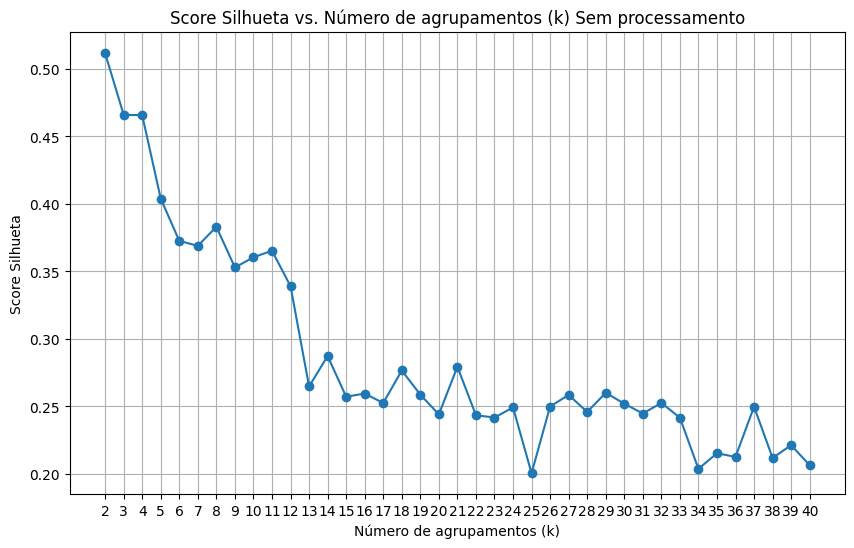

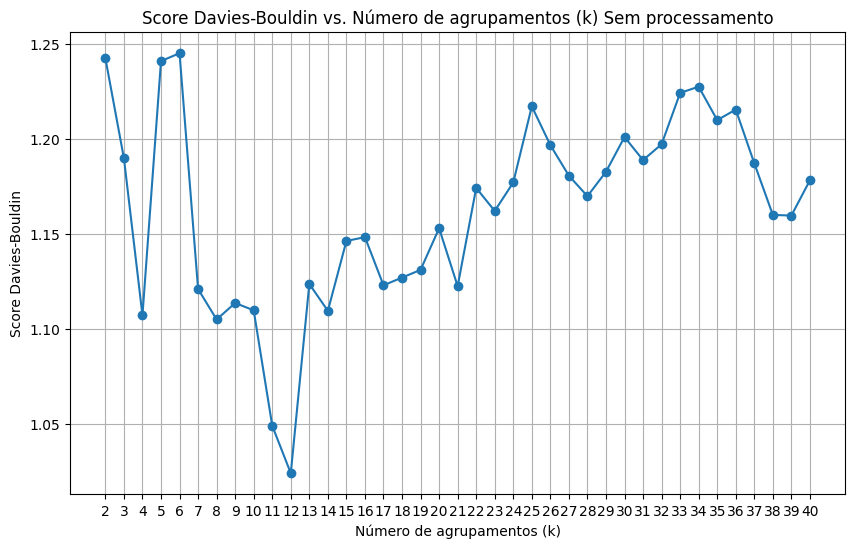

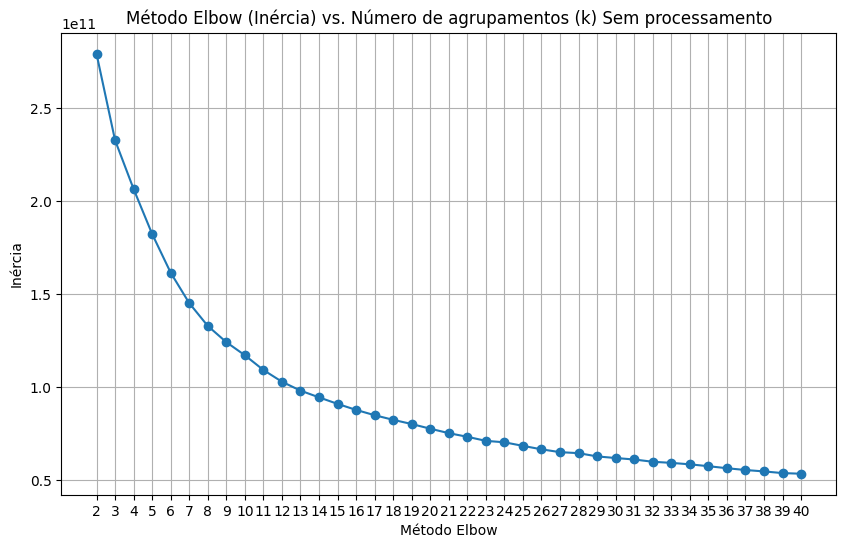

In [ ]:
db_no_proc, sil_no_proc, inert_no_proc = generate_graph(df, 40, "Sem processamento")

## Cenário 2: base suavizada

Neste cenário, aplicamos uma técnica de **suavização** com o objetivo de atenuar ruídos e flutuações pontuais nos dados. Especificamente, realizamos a **remoção de outliers**, que são valores extremos capazes de distorcer a formação dos clusters e comprometer a qualidade da análise.

Com a base suavizada, repetimos o processo de clusterização utilizando os mesmos algoritmos e intervalo de valores de `k`.


In [ ]:
df_suavizado = df.copy()

In [ ]:
cols = df_suavizado.columns

for col in cols:
  initial_rows = len(df_suavizado)
  df_suavizado = remove_outliers_iqr(df_suavizado, col)
  rows_removed = initial_rows - len(df_suavizado)
  print(f"{rows_removed} outliers removidos da coluna '{col}'. Linhas restantes: {len(df_suavizado)}")

print(f'O dataset suavizado após a remoção de outliers tem {len(df_suavizado)} linhas.')

695 outliers removidos da coluna 'BALANCE'. Linhas restantes: 8255
1201 outliers removidos da coluna 'BALANCE_FREQUENCY'. Linhas restantes: 7054
580 outliers removidos da coluna 'PURCHASES'. Linhas restantes: 6474
643 outliers removidos da coluna 'ONEOFF_PURCHASES'. Linhas restantes: 5831
456 outliers removidos da coluna 'INSTALLMENTS_PURCHASES'. Linhas restantes: 5375
505 outliers removidos da coluna 'CASH_ADVANCE'. Linhas restantes: 4870
0 outliers removidos da coluna 'PURCHASES_FREQUENCY'. Linhas restantes: 4870
484 outliers removidos da coluna 'ONEOFF_PURCHASES_FREQUENCY'. Linhas restantes: 4386
0 outliers removidos da coluna 'PURCHASES_INSTALLMENTS_FREQUENCY'. Linhas restantes: 4386
268 outliers removidos da coluna 'CASH_ADVANCE_FREQUENCY'. Linhas restantes: 4118
207 outliers removidos da coluna 'CASH_ADVANCE_TRX'. Linhas restantes: 3911
115 outliers removidos da coluna 'PURCHASES_TRX'. Linhas restantes: 3796
257 outliers removidos da coluna 'CREDIT_LIMIT'. Linhas restantes: 3539


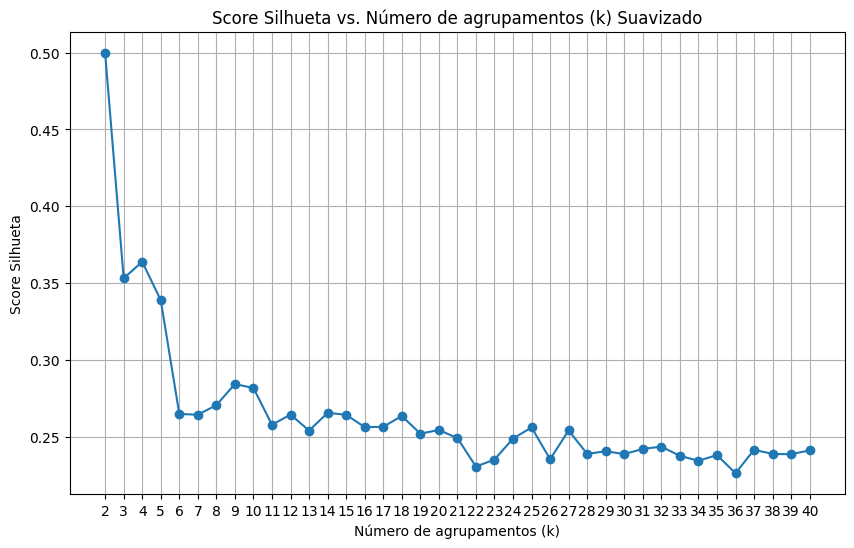

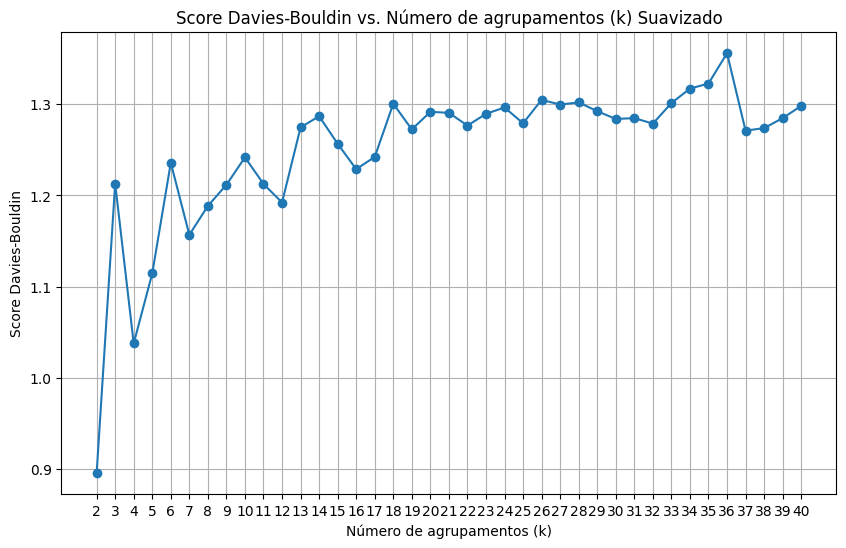

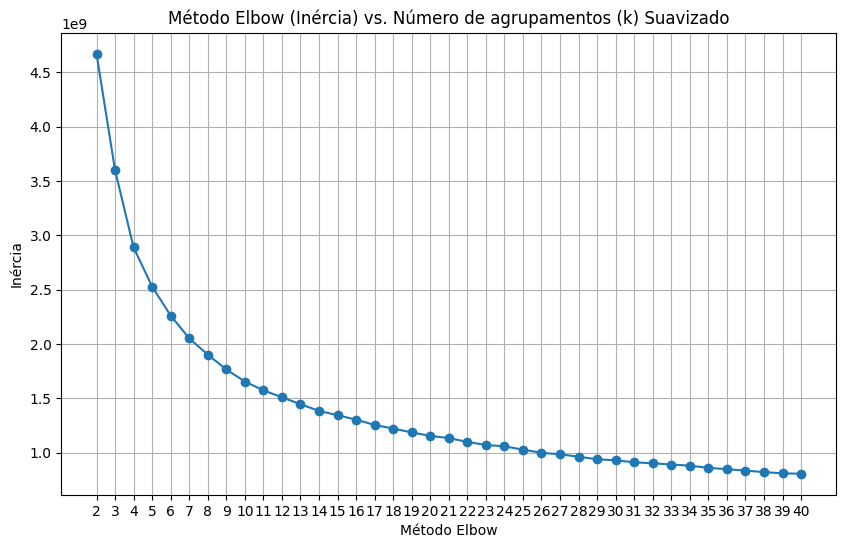

In [ ]:
db_soft, sil_soft, inert_soft = generate_graph(df_suavizado, 40, "Suavizado")

## Cenário 3: base suavizada e normalizada

Neste terceiro e último cenário, aplicamos uma combinação de duas etapas de pré-processamento: **suavização** (já realizada no cenário anterior) e **normalização** dos dados. A normalização é fundamental em algoritmos baseados em distância, como o K-Means, pois garante que todas as variáveis contribuam de forma equilibrada no processo de agrupamento — independentemente de suas escalas originais.

Optamos pela técnica de **normalização min-max**, que transforma os dados para o intervalo entre 0 e 1. Com isso, evitamos que variáveis com magnitudes maiores dominem a formação dos clusters. Com a base devidamente normalizada, repetimos os experimentos de clustering.

In [ ]:
df_normalizado = df_suavizado.copy()

In [ ]:
scaler = MinMaxScaler()
df_normalizado[df_normalizado.columns] = scaler.fit_transform(df_normalizado[df_normalizado.columns])

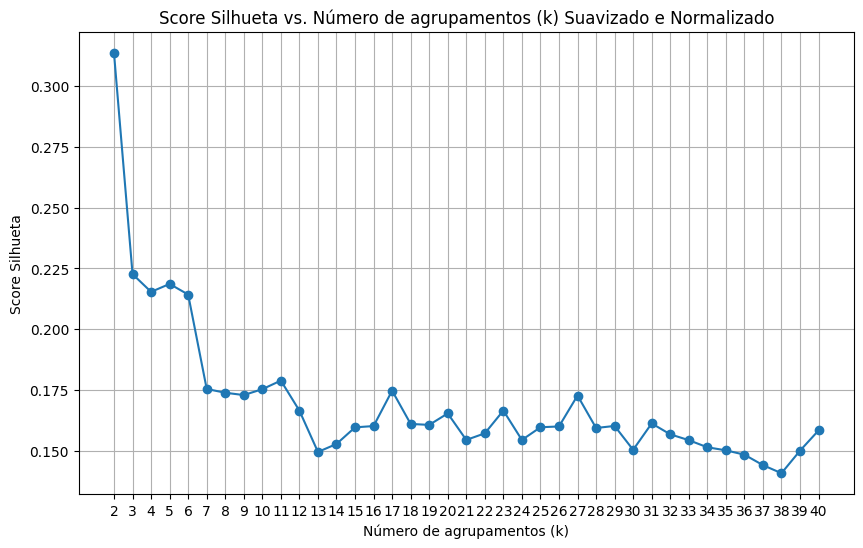

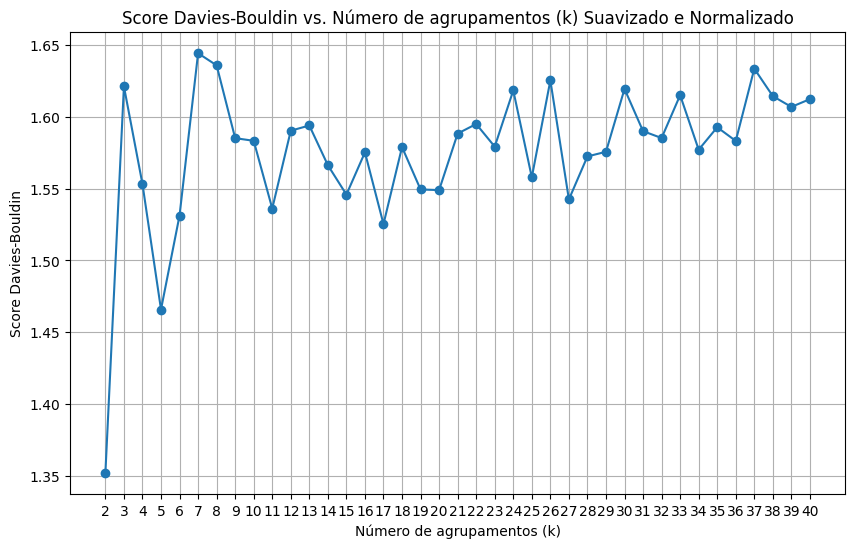

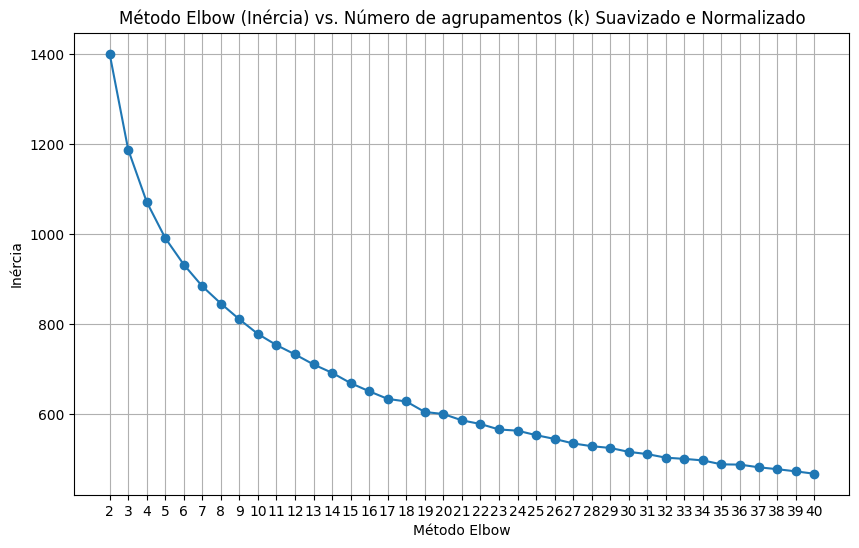

In [ ]:
db_norm, sil_norm, inert_norm = generate_graph(df_normalizado, 40, "Suavizado e Normalizado")


# Análise dos resultados obtidos

Passamos agora para a análise dos resultados obtidos. Uma visualização rápida dos gráficos projetados nos dá uma ideia de que 2 parece ser o número ideal de k agrupamentos. Para tirarmos a dúvida, criaremos um dataframe com todos os nossos resultados e utilizaremos uma função para calcular o melhor k para cada dataset que preparemos no nosso estudo.

In [ ]:
import pandas as pd
index_values = range(2, 41)
results_df = pd.DataFrame({
    'k': index_values,
    'db_no_proc': db_no_proc,
    'sil_no_proc': sil_no_proc,
    'inert_no_proc': inert_no_proc,
    'db_soft': db_soft,
    'sil_soft': sil_soft,
    'inert_soft': inert_soft,
    'db_norm': db_norm,
    'sil_norm': sil_norm,
    'inert_norm': inert_norm
})
results_df.head()

,k,db_no_proc,sil_no_proc,inert_no_proc,db_soft,sil_soft,inert_soft,db_norm,sil_norm,inert_norm
0,2,1.242451,0.511639,2.792966e+11,0.895679,0.499587,4.669758e+09,1.351863,0.313550,1400.730289
1,3,1.189786,0.466019,2.328022e+11,1.212921,0.353191,3.599616e+09,1.621201,0.222668,1187.828689
2,4,1.107049,0.465712,2.065547e+11,1.037855,0.363965,2.889107e+09,1.553216,0.215367,1071.530480
3,5,1.240944,0.403926,1.823587e+11,1.114541,0.338919,2.528838e+09,1.465854,0.218632,991.242659
4,6,1.245097,0.372643,1.615349e+11,1.235810,0.264998,2.262100e+09,1.531277,0.214262,932.335718


A função `compute_scores` tem como objetivo calcular uma pontuação para avaliar a qualidade dos agrupamentos nos três cenários analisados. Para isso, ela utiliza as três métricas de validação que escolhemos — Davies-Bouldin, Silhouette e Inércia — aplicando a normalização Min-Max para garantir que todas tenham a mesma escala entre 0 e 1. Como valores baixos são melhores para Davies-Bouldin e Inércia, essas métricas são invertidas antes da normalização. Em seguida, nossa função calcula a média das métricas normalizadas para cada cenário, resultando em um score final que representa a qualidade do agrupamento. Por fim, ela identifica o valor de k (número de clusters) que apresenta a melhor pontuação em cada cenário e retorna esses valores juntamente com o DataFrame contendo os scores calculados.

In [ ]:
def compute_scores(df):
    df = df.copy()

    scaler = MinMaxScaler()

    for col in ['db_no_proc', 'db_soft', 'db_norm']:
        df[col + '_norm'] = scaler.fit_transform((-df[col]).values.reshape(-1, 1)).flatten()  # menor é melhor → inverte
    for col in ['sil_no_proc', 'sil_soft', 'sil_norm']:
        df[col + '_norm'] = scaler.fit_transform(df[col].values.reshape(-1, 1)).flatten()  # maior é melhor
    for col in ['inert_no_proc', 'inert_soft', 'inert_norm']:
        df[col + '_norm'] = scaler.fit_transform((-df[col]).values.reshape(-1, 1)).flatten()  # menor é melhor → inverte

    df['score_no_proc'] = df[['db_no_proc_norm', 'sil_no_proc_norm', 'inert_no_proc_norm']].mean(axis=1)
    df['score_soft'] = df[['db_soft_norm', 'sil_soft_norm', 'inert_soft_norm']].mean(axis=1)
    df['score_norm'] = df[['db_norm_norm', 'sil_norm_norm', 'inert_norm_norm']].mean(axis=1)

    best_k_no_proc = df.loc[df['score_no_proc'].idxmax(), 'k']
    best_k_soft = df.loc[df['score_soft'].idxmax(), 'k']
    best_k_norm = df.loc[df['score_norm'].idxmax(), 'k']

    return best_k_no_proc, best_k_soft, best_k_norm, df[['k', 'score_no_proc', 'score_soft', 'score_norm']]




Para facilitar a visualização, vamos usar uma função que cria um dataframe com os melhores resultados obtidos para cada cenário.

In [ ]:
def get_best_k_row(df):
    best_k_no_proc, best_k_soft, best_k_norm, scores_df = compute_scores(df)

    # Recuperar as melhores linhas
    best_row_no_proc = scores_df[scores_df['k'] == best_k_no_proc]
    best_row_soft = scores_df[scores_df['k'] == best_k_soft]
    best_row_norm = scores_df[scores_df['k'] == best_k_norm]

    # Juntar todas as melhores linhas em um único DataFrame
    best_rows = pd.concat([
        best_row_no_proc.assign(cenario='Sem Processamento'),
        best_row_soft.assign(cenario='Suavizado'),
        best_row_norm.assign(cenario='Suavizado + Normalizado')
    ])

    return best_rows


In [ ]:
melhores_linhas = get_best_k_row(results_df)
display(melhores_linhas)

,k,score_no_proc,score_soft,score_norm,cenario
10,12,0.742027,0.437678,0.349769,Sem Processamento
0,2,0.337320,0.666667,0.666667,Suavizado
0,2,0.337320,0.666667,0.666667,Suavizado + Normalizado


Concluímos que, de fato, o dataset normalizado e suavizado parece funcionar melhor com 2 agrupamentos. Vejamos uma outra forma de visualizar a conclusão obtida

# Visualização do dataset

A visualização dos dados com os algoritmos UMAP e t-SNE permite observar como os registros do nosso dataset se distribuem em um espaço tridimensional reduzido. No caso, tanto o UMAP quanto o t-SNE foram utilizados para projetar os dados normalizados em 3D, com os clusters atribuídos pelo algoritmo KMeans. A visualização resultante mostrou que, em ambos os casos, os pontos se organizaram em dois grupos principais — condizentes com a escolha de k=2. No entanto, o UMAP apresentou uma separação mais clara e visivelmente distante entre os clusters, enquanto o t-SNE gerou uma divisão mais próxima e compacta, com possível sobreposição de bordas.

Essa diferença na visualização está diretamente ligada à forma como cada algoritmo trabalha. O t-SNE foca em preservar estruturas locais — ou seja, ele tenta garantir que pontos próximos no espaço original permaneçam próximos na projeção, mesmo que isso distorça as distâncias globais. Já o UMAP preserva tanto relações locais quanto globais, o que resulta em uma representação mais fiel das distâncias reais entre grupos. Por isso, no experimento, a separação visualmente mais evidente entre os clusters no UMAP sugere que ele conseguiu capturar melhor a estrutura geral dos dados — indicando que os grupos formados são mais distintos em termos globais.

Por fim, deve-se ter em mente que a redução de dimensionalidade, embora útil para visualização e simplificação dos dados, pode ocasionalmente apagar ou distorcer características importantes dos grupos originais. Ao comprimir um espaço de muitas variáveis em duas ou três dimensões, algumas relações complexas entre os atributos podem ser perdidas ou suavizadas. Ou seja, trata-se somente de um artifício para melhor exibição do nosso dataset.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


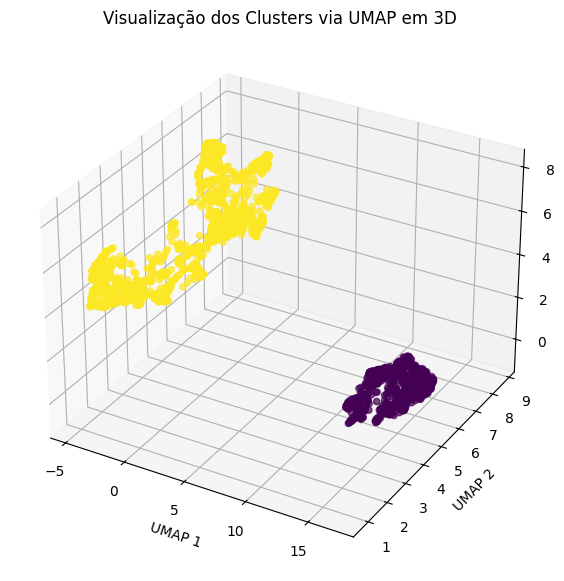

In [ ]:
np.random.seed(43)

kmeans = KMeans(n_clusters=2, init='k-means++', random_state=43, n_init=10)
df_normalizado['cluster'] = kmeans.fit_predict(df_normalizado)

X = df_normalizado.values

reducer_3d = umap.UMAP(n_components=3, random_state=43)
umap_result_3d = reducer_3d.fit_transform(X)

df_normalizado['umap-1'] = umap_result_3d[:, 0]
df_normalizado['umap-2'] = umap_result_3d[:, 1]
df_normalizado['umap-3'] = umap_result_3d[:, 2]

# Plotar UMAP em 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_normalizado['umap-1'], df_normalizado['umap-2'], df_normalizado['umap-3'], c=df_normalizado['cluster'], cmap='viridis', alpha=0.7)
ax.set_title("Visualização dos Clusters via UMAP em 3D")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
plt.show()


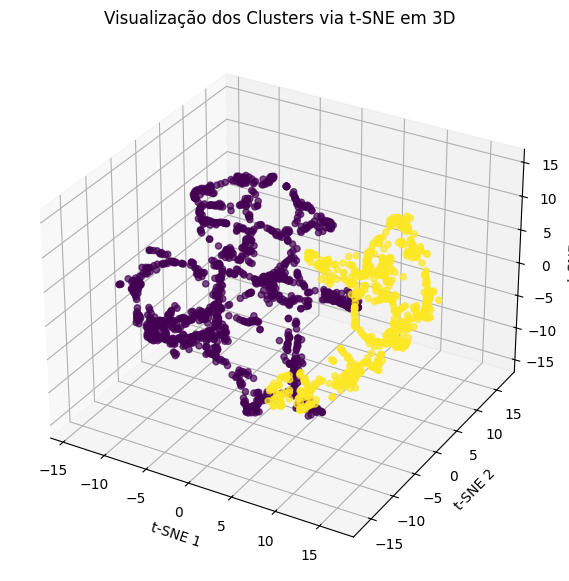

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necessário para visualização 3D

# Definir semente aleatória
np.random.seed(43)

# Aplicar KMeans com k=2
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=43, n_init=10)
df_normalizado['cluster'] = kmeans.fit_predict(df_normalizado)

# Dados para redução de dimensionalidade
X = df_normalizado.drop(columns='cluster').values

# Aplicar t-SNE em 3D
tsne_3d = TSNE(n_components=3, random_state=43, perplexity=30, learning_rate=100)
tsne_result_3d = tsne_3d.fit_transform(X)

# Adicionar colunas ao DataFrame
df_normalizado['tsne-1'] = tsne_result_3d[:, 0]
df_normalizado['tsne-2'] = tsne_result_3d[:, 1]
df_normalizado['tsne-3'] = tsne_result_3d[:, 2]

# Plotar t-SNE em 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_normalizado['tsne-1'], df_normalizado['tsne-2'], df_normalizado['tsne-3'],
           c=df_normalizado['cluster'], cmap='viridis', alpha=0.7)
ax.set_title("Visualização dos Clusters via t-SNE em 3D")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.show()


# Análise por gráficos

Para finalizar nossa exploração do dataset, criamos alguns gráficos que nos possibilitam visualizar as diferenças entre os agrupamentos de forma mais direta.

O gráfico de radar apresenta a distribuição de todas as features de cada cluster. O cluster 0 (esquerda) pode ser caracterizado como o grupo de clientes de "Maior Risco". Estes clientes mantêm saldos mais altos (`BALANCE`) e recorrem mais a adiantamentos em dinheiro (`CASH_ADVANCE`). A sua atividade de compras é menor (`PURCHASE_TRX`), e possuem limites de crédito mais baixos (`CREDIT_LIMIT`). Podem ser clientes que utilizam o cartão mais como uma forma de empréstimo.

O cluster 1 indica possuir clientes de "Menor Risco". Estes clientes utilizam o cartão intensamente para compras, possuem limites de crédito mais altos e demonstram um comportamento de pagamento mais saudável, liquidando a fatura na totalidade com maior frequência (`PAYMENTS`). Utilizam menos os adiantamentos em dinheiro e mantêm saldos devedores médios mais baixos (`MINIMUM_PAYMENTS`). Podem ser vistos como clientes que fazem uma boa gestão das suas finanças.

Os box plots gerados para cada atributo permitir ver as diferenças de clusters de modo pormenorizado.

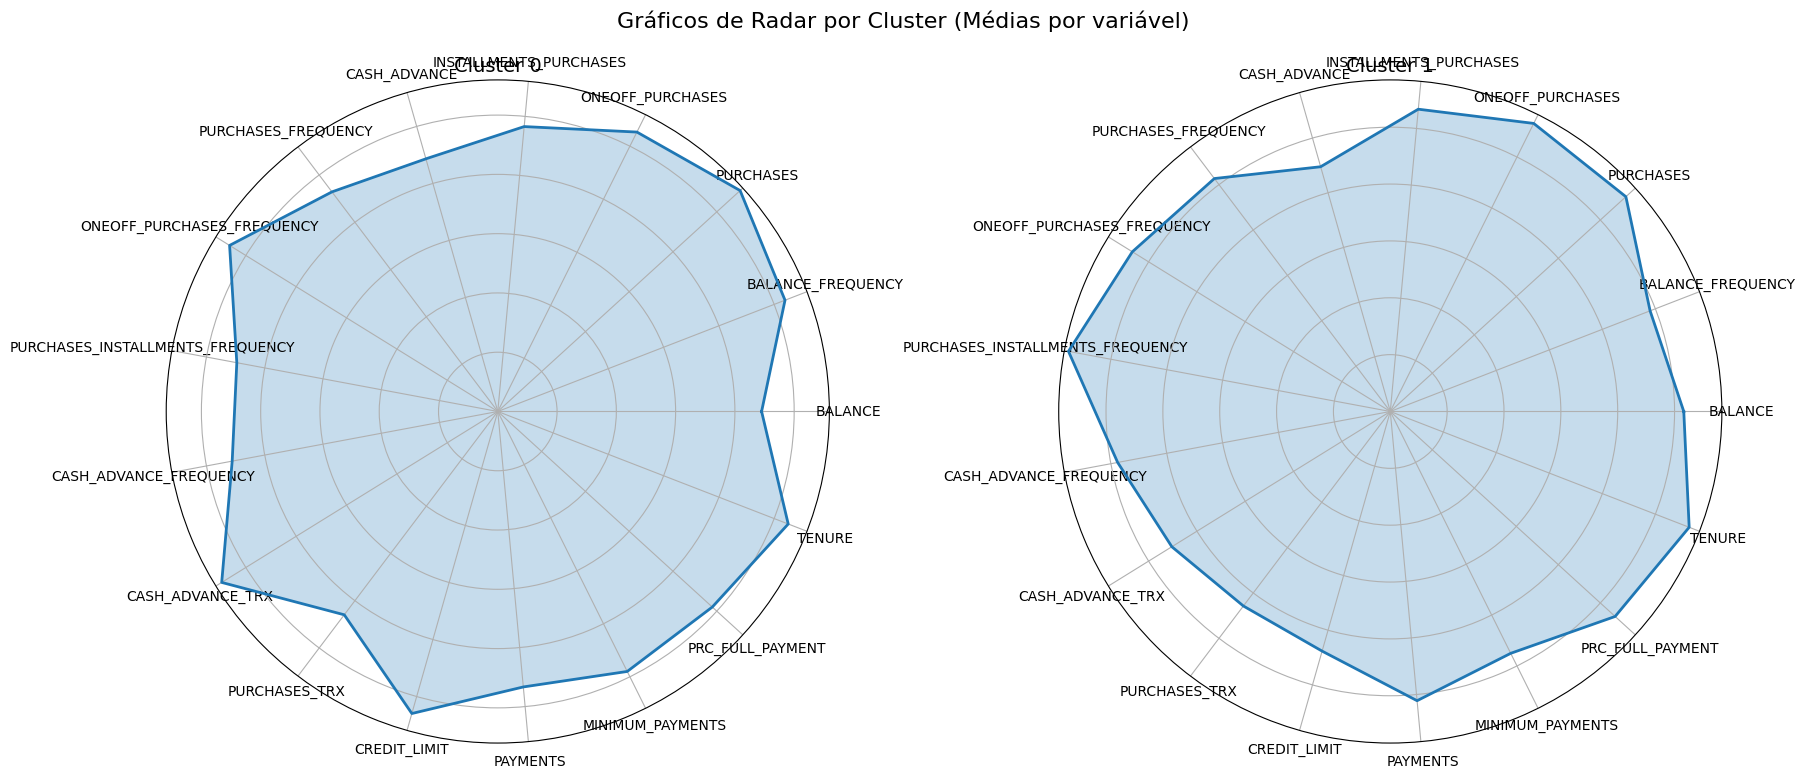

In [ ]:
# Variáveis selecionadas
selected_features = [
    'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
    'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
    'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
    'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
    'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
    'TENURE'
]

# Simular DataFrame com clusters e valores normalizados
np.random.seed(42)
df_cluster = pd.DataFrame(np.random.rand(100, len(selected_features)), columns=selected_features)
df_cluster['cluster'] = np.random.choice([0, 1], size=100)

# Calcular a média por cluster
cluster_means = df_cluster.groupby('cluster')[selected_features].mean()

# Preparar dados para o gráfico de radar
labels = selected_features
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # fechar o círculo

# Plotar gráfico de radar para cada cluster
fig, axes = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(18, 8))

for i, cluster_id in enumerate(cluster_means.index):
    values = cluster_means.loc[cluster_id].tolist()
    values += values[:1]  # fechar o círculo

    ax = axes[i]
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(f'Cluster {cluster_id}', size=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])

plt.suptitle('Gráficos de Radar por Cluster (Médias por variável)', fontsize=16)
plt.tight_layout()
plt.show()


<ipython-input-26-bf985cf9e808>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feature, data=df_normalizado, palette='viridis')
<ipython-input-26-bf985cf9e808>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feature, data=df_normalizado, palette='viridis')
<ipython-input-26-bf985cf9e808>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feature, data=df_normalizado, palette='viridis')
<ipython-input-26-bf985cf9e808>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated 

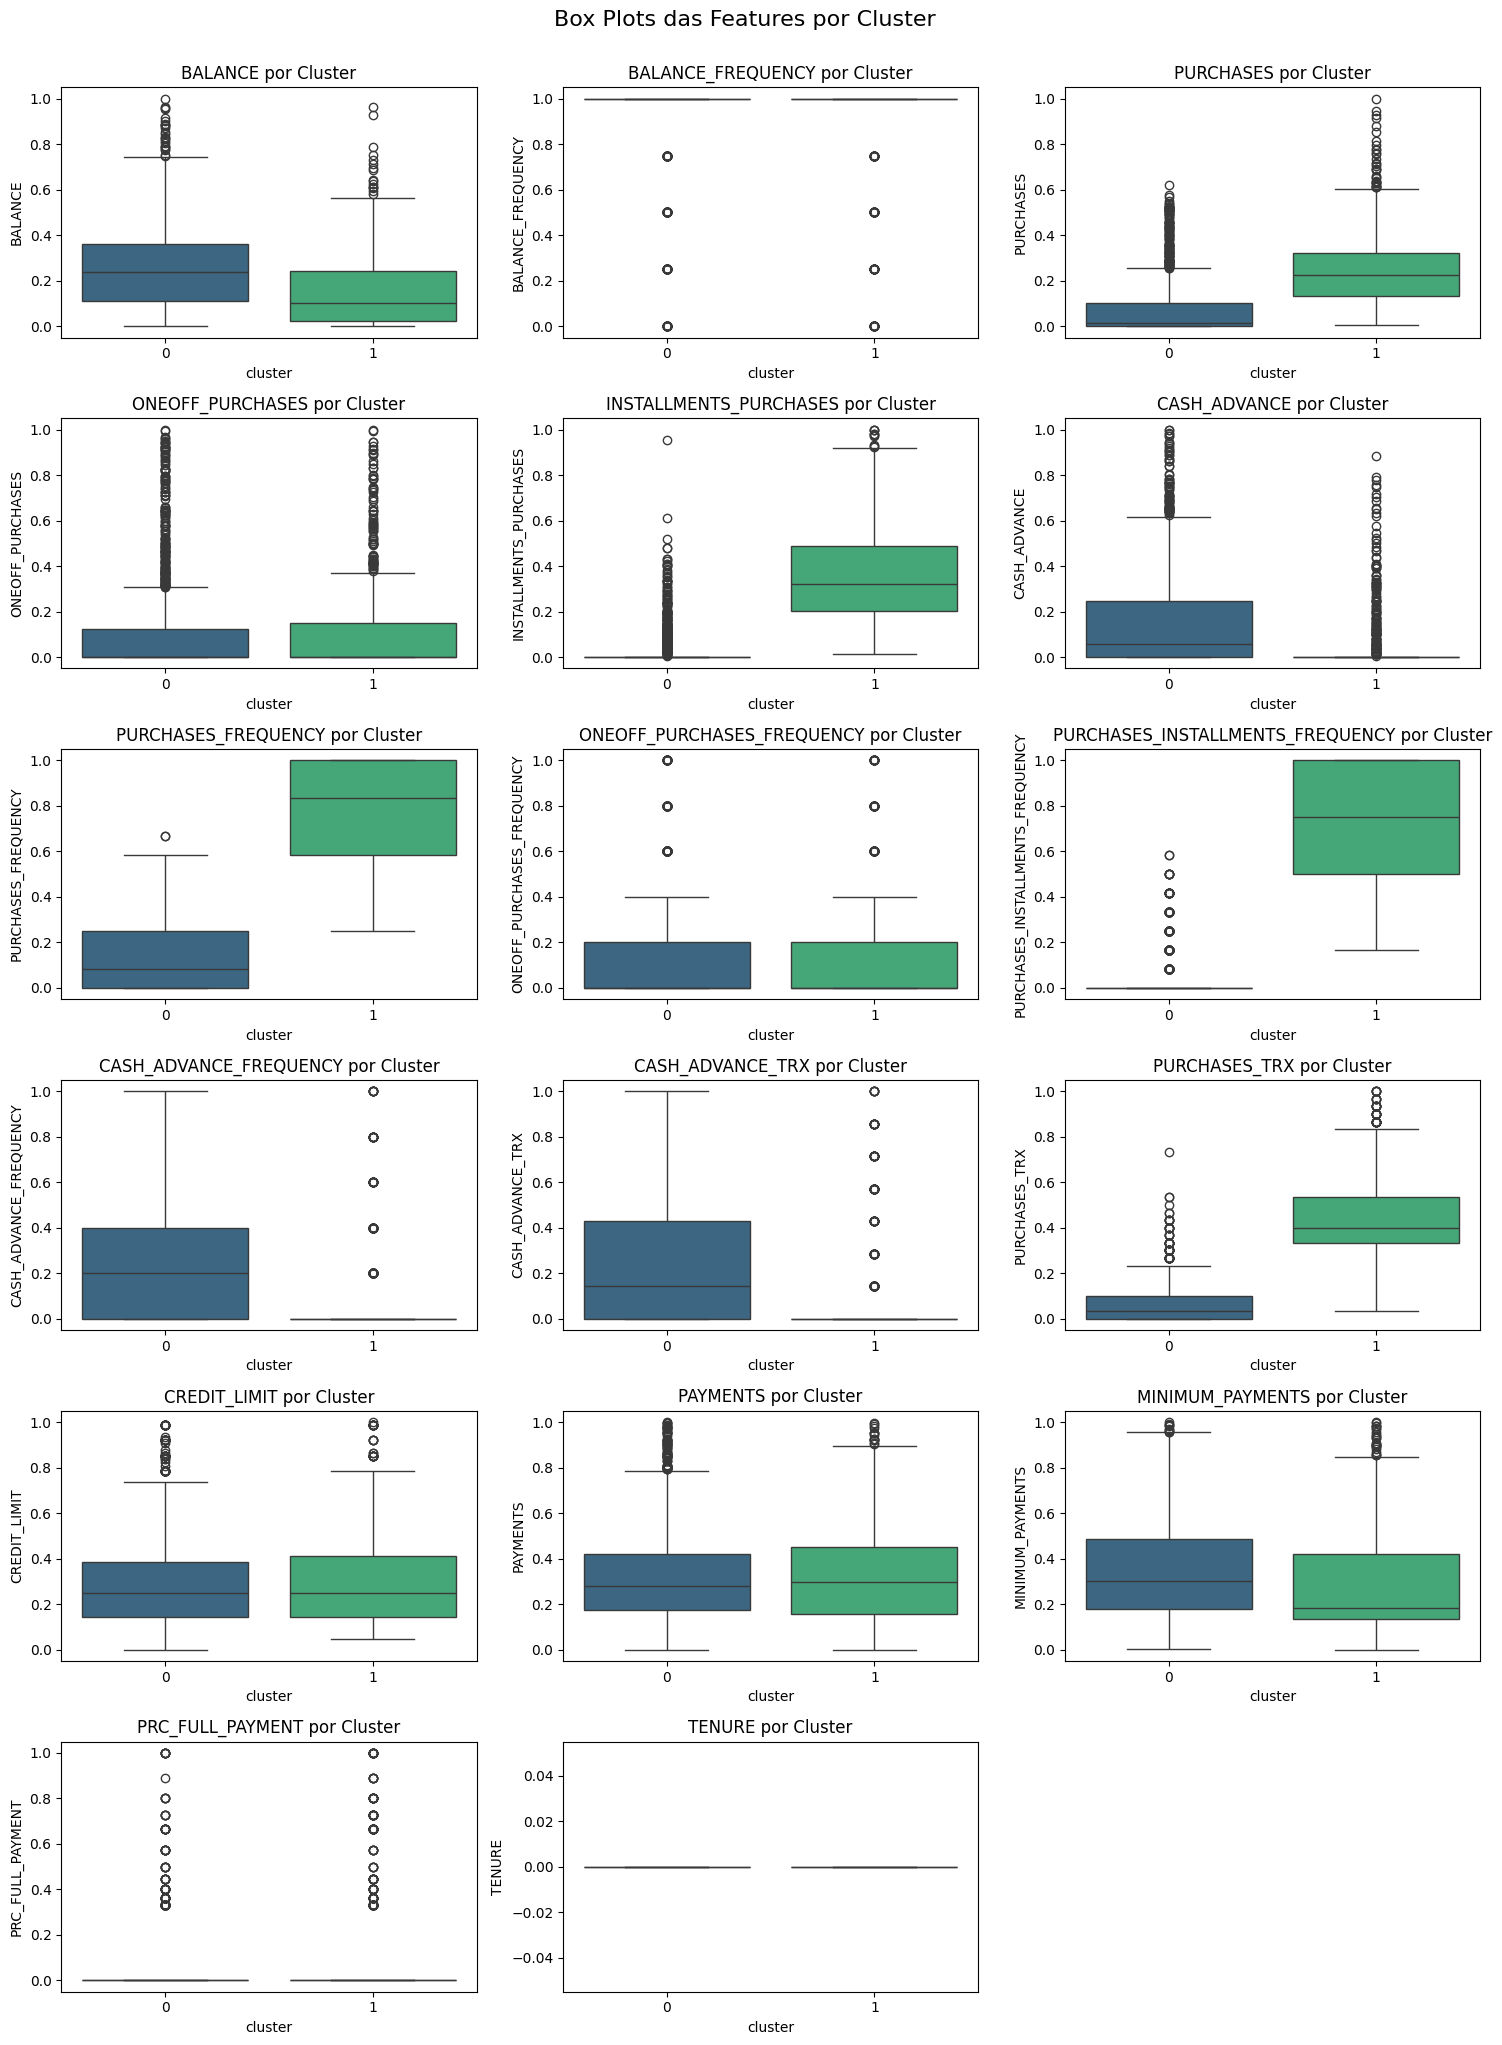

In [ ]:
columns = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
           'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
           'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
           'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
           'TENURE']

plt.figure(figsize=(15, 20))
for i, feature in enumerate(columns):
    plt.subplot(6, 3, i + 1) # Adjust subplot grid as needed
    sns.boxplot(x='cluster', y=feature, data=df_normalizado, palette='viridis')
    plt.title(f'{feature} por Cluster')
plt.tight_layout()
plt.suptitle('Box Plots das Features por Cluster', y=1.02, fontsize=16)
plt.show()

